# SY09 : Analyse descriptive de Starbucks Drinks

https://github.com/rfordatascience/tidytuesday/tree/master/data/2021/2021-12-21

## Import des données

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
from sklearn.decomposition import PCA
import numpy as np

In [34]:
starbucks = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-12-21/starbucks.csv')
print(starbucks.shape, "\n")
print(starbucks.columns)

(1147, 15) 

Index(['product_name', 'size', 'milk', 'whip', 'serv_size_m_l', 'calories',
       'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg',
       'sodium_mg', 'total_carbs_g', 'fiber_g', 'sugar_g', 'caffeine_mg'],
      dtype='object')


## Nettoyage des données

Toutes les variables quantitatives sont bien typées.
*Size* est une catégorie que l'on crée à partir de ses valeurs uniques.
*Milk* est une catégorie que l'on renomme ici pour la lisibilité des graphiques.
*Whip* est booléen.

In [35]:
starbucks["size"] = pd.Categorical(starbucks["size"], categories = starbucks["size"].unique())

starbucks["milk"] = starbucks['milk'].replace(0,"none")
starbucks["milk"] = starbucks['milk'].replace(1,"nonfat")
starbucks["milk"] = starbucks['milk'].replace(2,"2%")
starbucks["milk"] = starbucks['milk'].replace(3,"soy")
starbucks["milk"] = starbucks['milk'].replace(4,"coconut")
starbucks["milk"] = starbucks['milk'].replace(5,"whole")
starbucks["milk"] = pd.Categorical(starbucks["milk"], categories = starbucks["milk"].unique())

starbucks["whip"] = starbucks["whip"].astype("bool")

En se basant sur le travail de https://rpubs.com/saravargha/starbucks, on va essayer de créer une variable qui catégorise les boissons en fonction de leur nom.

Ses catégories sont : *Refresher*, *Smoothie*, *Tea*, *Coffee*, *Espresso*, *Frapuccino*, *Hot Chocolates & Others*

L'autrice ne fournit pas le code qui lui a permis de créer cette variable.

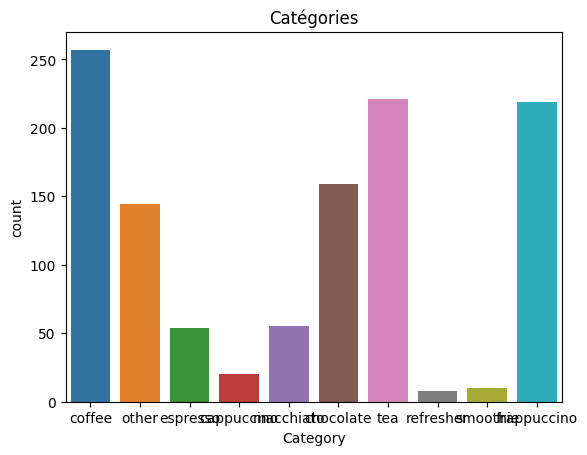

['Vanilla Sweet Cream Cold Brew' 'Cinnamon Dolce Latte' 'Flat White'
 'Skinny Cinnamon Dolce Latte' 'Iced Skinny Cinnamon Dolce Latte'
 'Skinny Mocha' 'Iced Skinny Mocha' 'Starbucks Doubleshot on ice'
 'Oprah Cinnamon Chai Latte' 'Iced Oprah Cinnamon Chai Latte'
 'Blended Strawberry Lemonade' 'Caramel Apple Spice' 'Lemonade'
 'Protein & Fibre Powder']


In [36]:
starbucks["Category"] = starbucks["product_name"].str.lower().str.extract("(caffè|chocolate|refresher|smoothie|tea|coffee|espresso|frappuccino|cappuccino|macchiato)")[0]
starbucks['Category'] = starbucks['Category'].fillna('other')
starbucks["Category"] = starbucks['Category'].replace('caffè',"coffee")

sns.countplot(x="Category",data=starbucks).set(title='Catégories')
plot.show()

test_cat = starbucks[starbucks['Category'] == 'other']
print(test_cat["product_name"].unique())

## Exploration des variables qualitatives

### *Category* : La catégorie de boisson

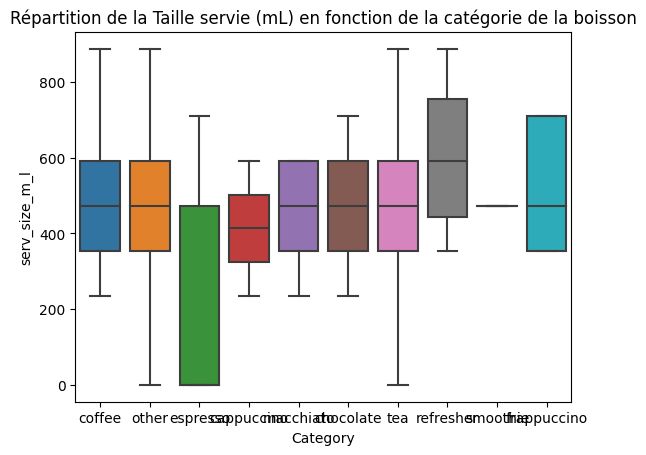

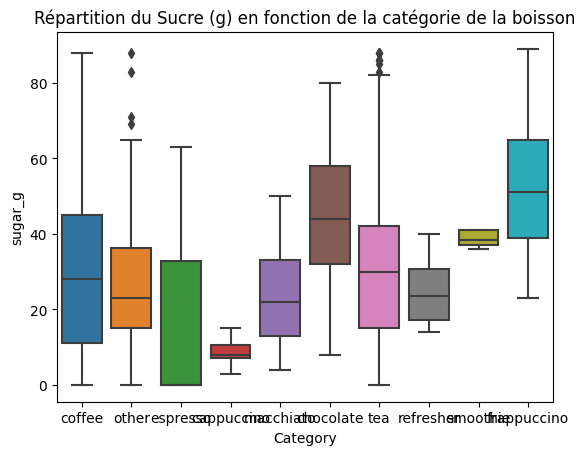

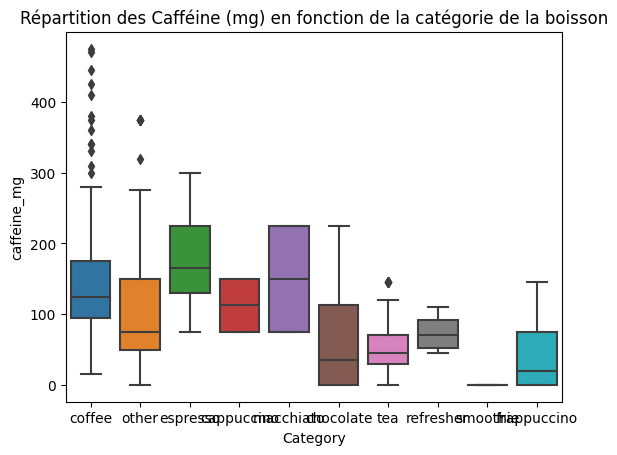

In [37]:
sns.boxplot(
    x="Category",
    y="serv_size_m_l",
    data=starbucks
    ).set(title='Répartition de la Taille servie (mL) en fonction de la catégorie de la boisson')
plot.show()

sns.boxplot(
    x="Category",
    y="sugar_g",
    data=starbucks
    ).set(title='Répartition du Sucre (g) en fonction de la catégorie de la boisson')
plot.show()

sns.boxplot(
    x="Category",
    y="caffeine_mg",
    data=starbucks
    ).set(title='Répartition des Cafféine (mg) en fonction de la catégorie de la boisson')
plot.show()

### *Product_Name* : Le nom des produits

On a créé *Category* à partir de cette variable. On peut vérifier l'unicité des noms de boissons.

In [38]:
print(starbucks["product_name"].nunique())
print(starbucks["product_name"].count())

93
1147


### *Milk* : Le type de lait 

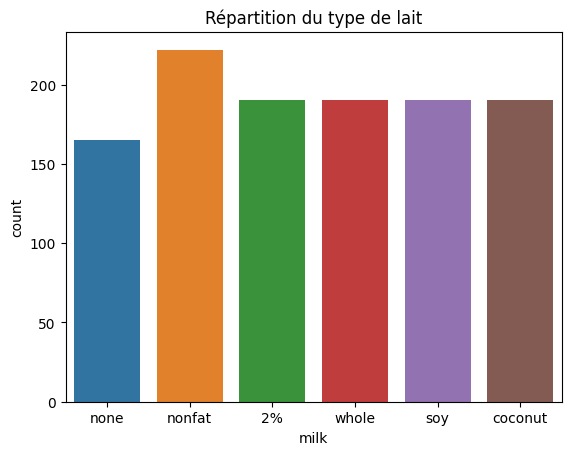

In [39]:
sns.countplot(x="milk",data=starbucks).set(title='Répartition du type de lait')
plot.show()

### *Size* : La taille de la boisson

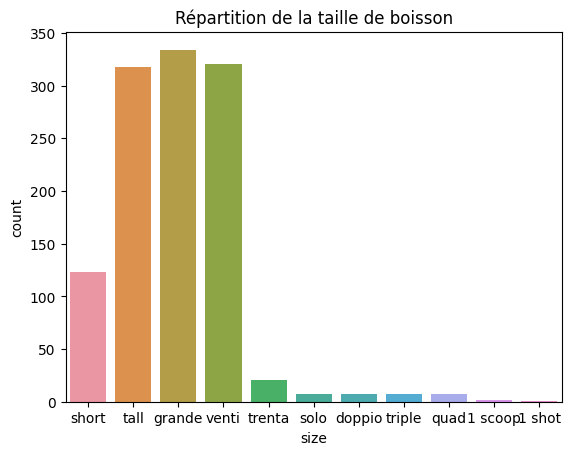

In [40]:
sns.countplot(x="size",data=starbucks).set(title='Répartition de la taille de boisson')
plot.show()

On observe plus de valeurs que ce qui était décrit dans la description du jeu de données. On peut parcourir les tailles atypiques.

In [41]:
print("Trenta")
print(starbucks[starbucks["size"] == "trenta"].shape)
print(starbucks[starbucks["size"] == "trenta"]["product_name"].unique())
print(starbucks[starbucks["size"] == "trenta"]["Category"].unique())
print("\n")

print("Solo")
print(starbucks[starbucks["size"] == "solo"].shape)
print(starbucks[starbucks["size"] == "solo"]["product_name"].unique())
print(starbucks[starbucks["size"] == "solo"]["Category"].unique())
print("\n")

print("Doppio")
print(starbucks[starbucks["size"] == "doppio"].shape)
print(starbucks[starbucks["size"] == "doppio"]["product_name"].unique())
print(starbucks[starbucks["size"] == "doppio"]["Category"].unique())
print("\n")

print("Triple")
print(starbucks[starbucks["size"] == "triple"].shape)
print(starbucks[starbucks["size"] == "triple"]["product_name"].unique())
print(starbucks[starbucks["size"] == "triple"]["Category"].unique())
print("\n")

print("Quad")
print(starbucks[starbucks["size"] == "quad"].shape)
print(starbucks[starbucks["size"] == "quad"]["product_name"].unique())
print(starbucks[starbucks["size"] == "quad"]["Category"].unique())
print("\n")

print("1 scoop")
print(starbucks[starbucks["size"] == "1 scoop"].shape)
print(starbucks[starbucks["size"] == "1 scoop"]["product_name"].unique())
print(starbucks[starbucks["size"] == "1 scoop"]["Category"].unique())
print("\n")

print("1 shot")
print(starbucks[starbucks["size"] == "1 shot"].shape)
print(starbucks[starbucks["size"] == "1 shot"]["product_name"].unique())
print(starbucks[starbucks["size"] == "1 shot"]["Category"].unique())

Trenta
(21, 16)
['Iced Coffee' 'Iced Coffee with milk' 'Cold Brewed Coffee'
 'Vanilla Sweet Cream Cold Brew' 'Iced Black tea'
 'Iced Black tea Lemonade' 'Iced Green Tea' 'Iced Green Tea Lemonade'
 'Iced Mango Black Tea' 'Iced Mango Black Tea Lemonade'
 'Iced Passion Tango Tea' 'Iced Passion Tango Tea Lemonade'
 'Peach Iced Green Tea' 'Peach Iced Green Tea Lemonade'
 'Cool Lime Starbucks Refreshers'
 'Very Berry Hibiscus Starbucks Refreshers' 'Lemonade']
['coffee' 'other' 'tea' 'refresher']


Solo
(7, 16)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


Doppio
(7, 16)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


Triple
(7, 16)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


Quad
(7, 16)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


1 scoop
(2, 16)
['Protein & Fibre Powder' 'Matcha Green Tea Powder']
['other' 'tea']


1 shot
(1, 16)
['Espresso shot']
['espresso']


On peut s'intéresser à la variable *serv_size_m_l* qui chiffre en mL la taille de la boisson, et à son lien avec notre variable qualitative.

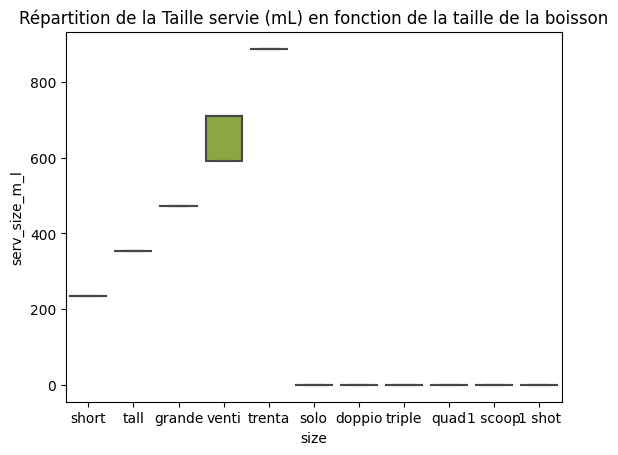

In [42]:
sns.boxplot(
    x="size",
    y="serv_size_m_l",
    data=starbucks
    ).set(title='Répartition de la Taille servie (mL) en fonction de la taille de la boisson')
plot.show()

On se rend compte que les deux variables sont extrêmement liées, on peut vérifier ce qu'il en est pour la taille *venti*.

<Axes: xlabel='serv_size_m_l', ylabel='count'>

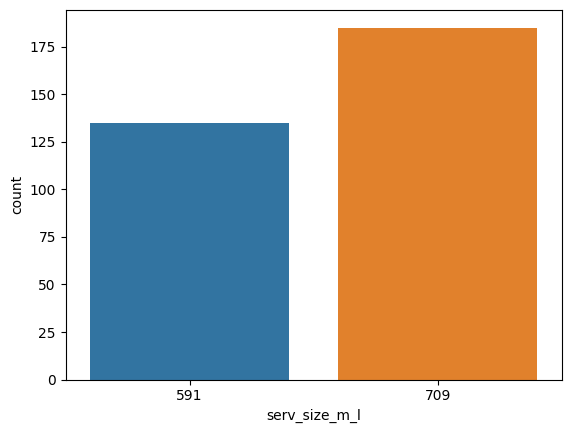

In [43]:
sns.countplot(x="serv_size_m_l",data=starbucks[starbucks['size'] == 'venti'])

On peut vérifier l'influence de la taille sur le sucre contenu dans la boisson.

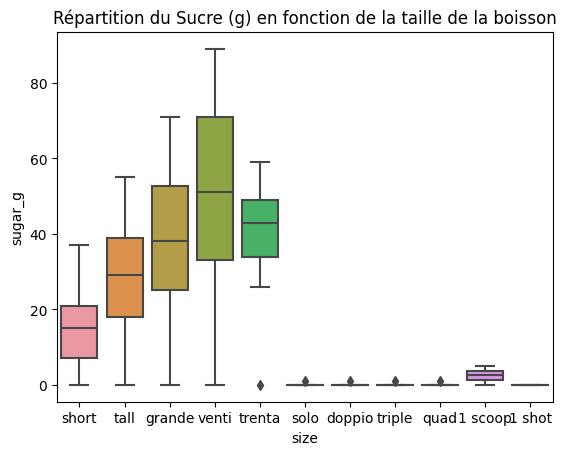

In [44]:
sns.boxplot(
    x="size",
    y="sugar_g",
    data=starbucks
    ).set(title='Répartition du Sucre (g) en fonction de la taille de la boisson')
plot.show()

On peut faire de même avec les calories.

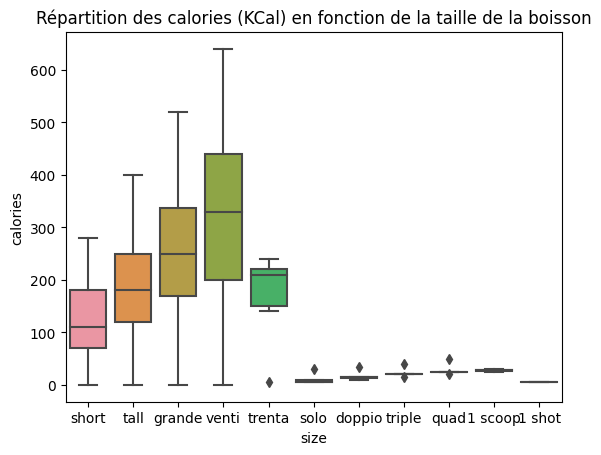

In [45]:
sns.boxplot(
    x="size",
    y="calories",
    data=starbucks
    ).set(title='Répartition des calories (KCal) en fonction de la taille de la boisson')
plot.show()

### *Whip* : La boisson a été fouettée ou non

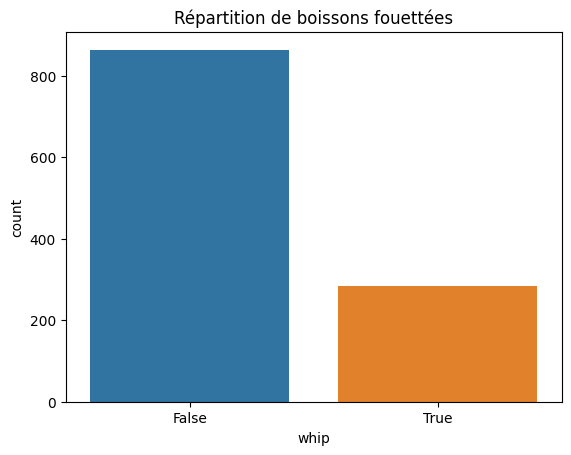

In [46]:
sns.countplot(x="whip",data=starbucks).set(title='Répartition de boissons fouettées')
plot.show()

On peut vérifier l'influence qu'a la variable *whip* sur les autres.

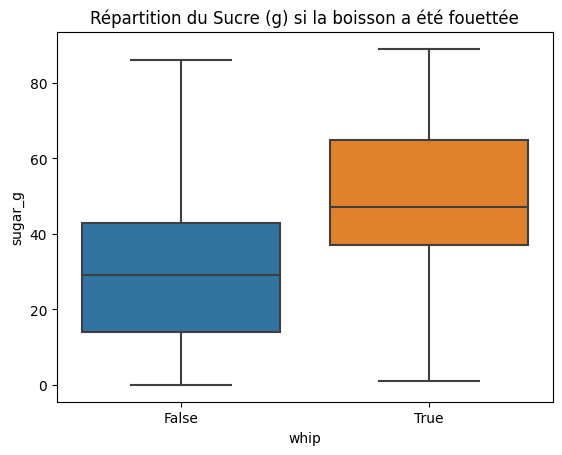

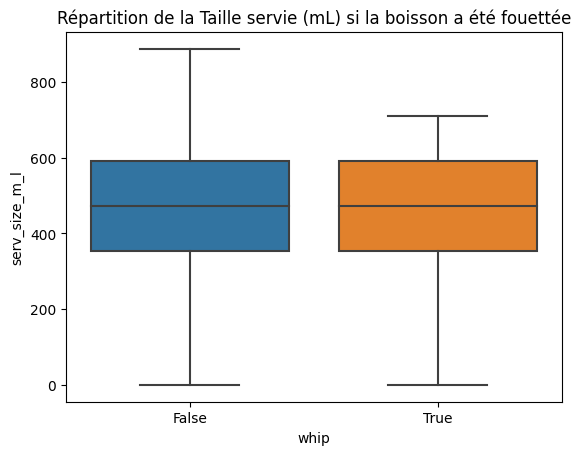

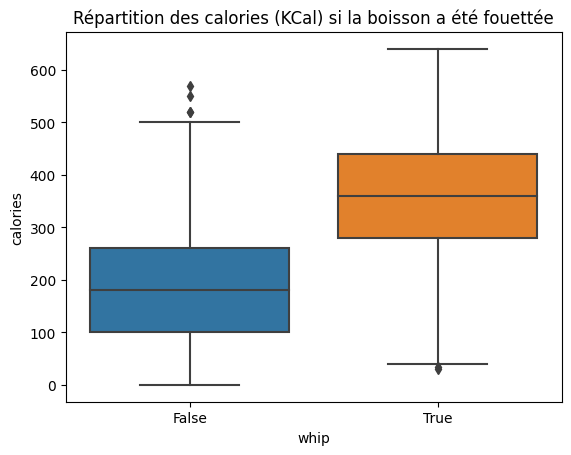

In [47]:
sns.boxplot(
    x="whip",
    y="sugar_g",
    data=starbucks
    ).set(title='Répartition du Sucre (g) si la boisson a été fouettée')
plot.show()

sns.boxplot(
    x="whip",
    y="serv_size_m_l",
    data=starbucks
    ).set(title='Répartition de la Taille servie (mL) si la boisson a été fouettée')
plot.show()

sns.boxplot(
    x="whip",
    y="calories",
    data=starbucks
    ).set(title='Répartition des calories (KCal) si la boisson a été fouettée')
plot.show()

## Exploration des corrélations

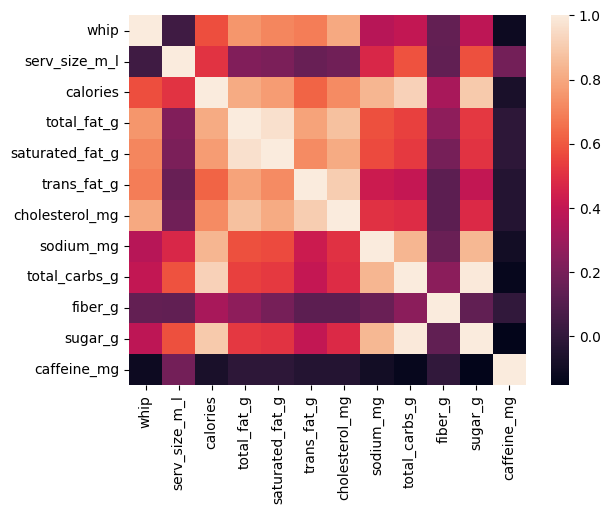

In [48]:
corr = starbucks.corr()
sns.heatmap(corr, annot = False)
plot.show()

### Calories et Sucres

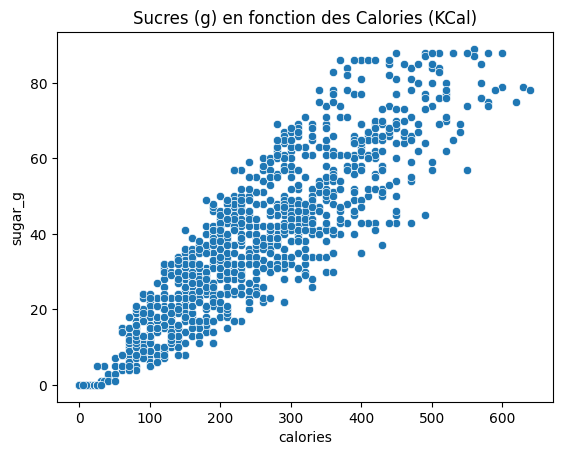

In [49]:
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    data = starbucks
    ).set(title='Sucres (g) en fonction des Calories (KCal)')
plot.show()

### Calories et Sodium

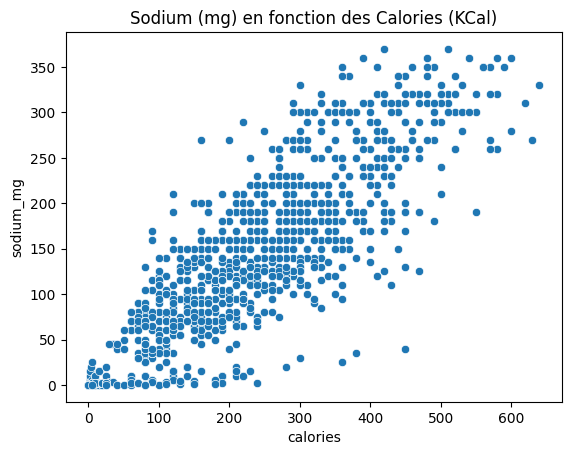

In [50]:
sns.scatterplot(
    x = "calories",
    y = "sodium_mg",
    data = starbucks
    ).set(title='Sodium (mg) en fonction des Calories (KCal)')
plot.show()

### Sucres et Glucides

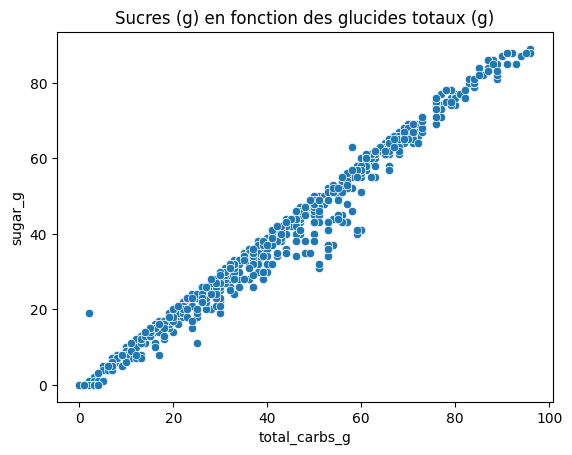

In [51]:
sns.scatterplot(
    x = "total_carbs_g",
    y = "sugar_g",
    data = starbucks
    ).set(title='Sucres (g) en fonction des glucides totaux (g)')
plot.show()

## Analyse en Composantes Principales

### Premier essai : Cluster sur la taille

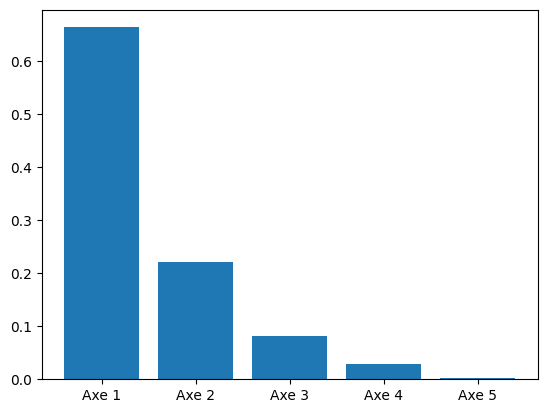

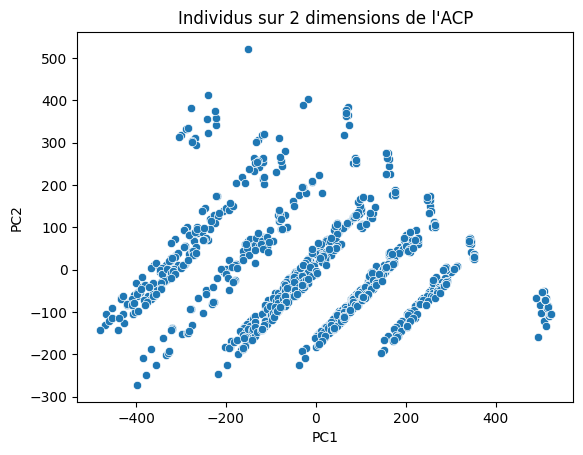

In [52]:
n_comp = 5
starbucks_acp1 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "Category"]).copy()

cls = PCA(n_components = n_comp)
pcs = cls.fit_transform(starbucks_acp1)

plot.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"],cls.explained_variance_ratio_)
plot.show()

for i in range(0, n_comp):
    starbucks['PC' + str(i + 1)] = pcs[:, i]

sns.scatterplot(x="PC1", y="PC2", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP")
plot.show()

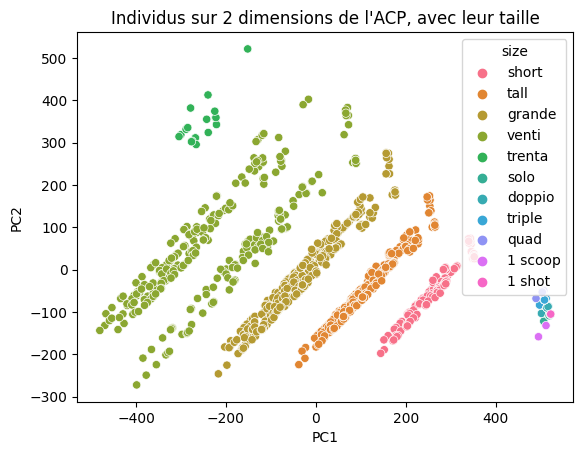

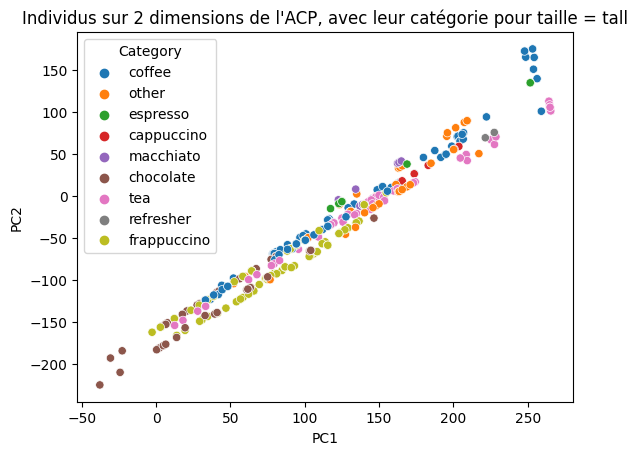

In [53]:
sns.scatterplot(x="PC1", y="PC2", hue="size", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
plot.show()

On trouve une ACP qui regroupe les boissons selon leur taille, mais on ne trouve rien de pertinent avec les variables *whip*, *milk* ou *category*. On essaye maintenant de qualifier les axes.

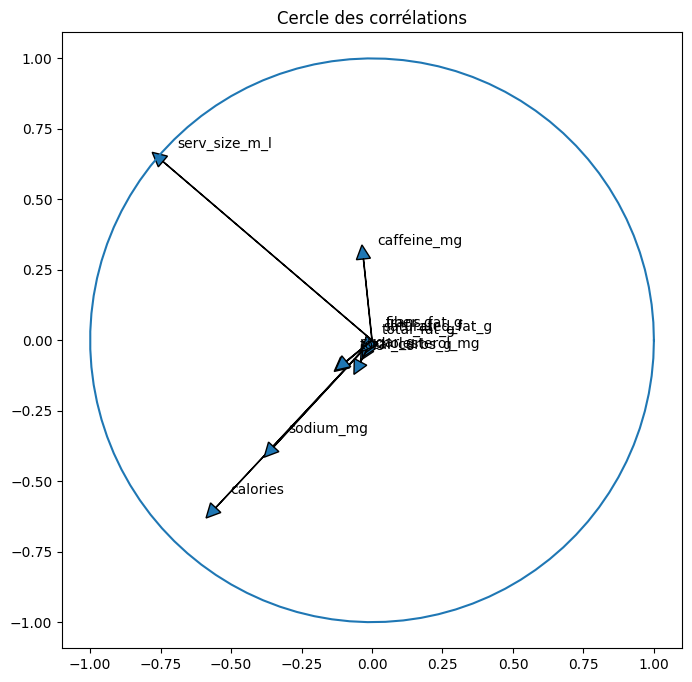

In [54]:
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls.components_[0, i],  #0 for PC1
             cls.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls.components_[0, i] + 0.05,
             cls.components_[1, i] + 0.05,
             starbucks_acp1.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations')
plot.show()

### Deuxième essai : Sans *serv_size_m_l*

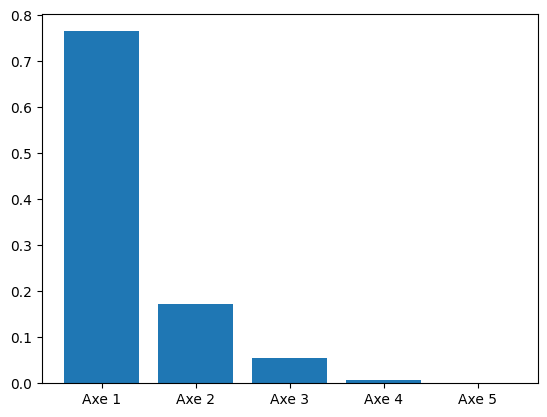

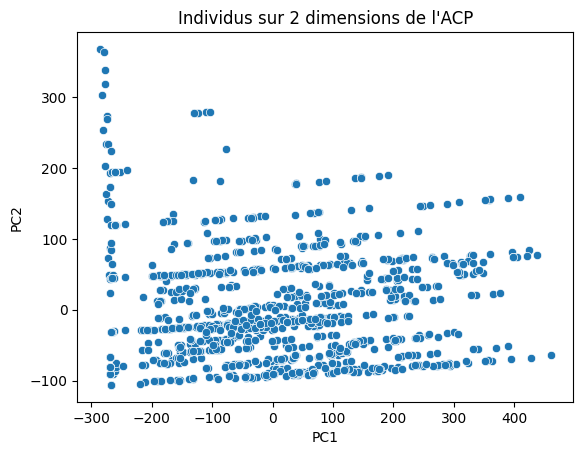

In [55]:
n_comp = 5
starbucks_acp2 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "Category", "serv_size_m_l", "PC1", "PC2", "PC3", "PC4", "PC5"]).copy()

cls2 = PCA(n_components = n_comp)
pcs2 = cls2.fit_transform(starbucks_acp2)

plot.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"],cls2.explained_variance_ratio_)
plot.show()

for i in range(0, n_comp):
    starbucks['PC' + str(i + 1)] = pcs2[:, i]

sns.scatterplot(x="PC1", y="PC2", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP")
plot.show()

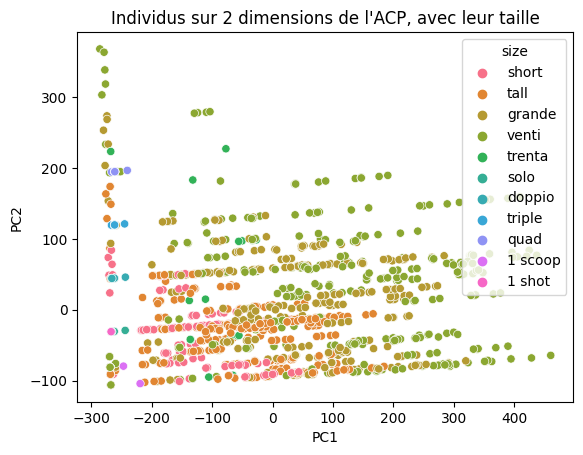

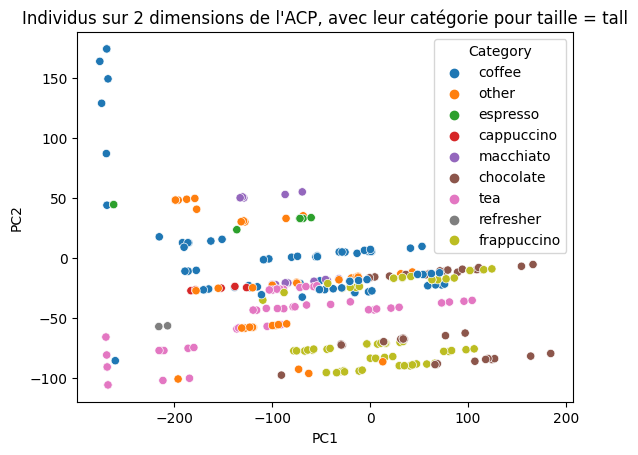

In [56]:
sns.scatterplot(x="PC1", y="PC2", hue="size", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
plot.show()

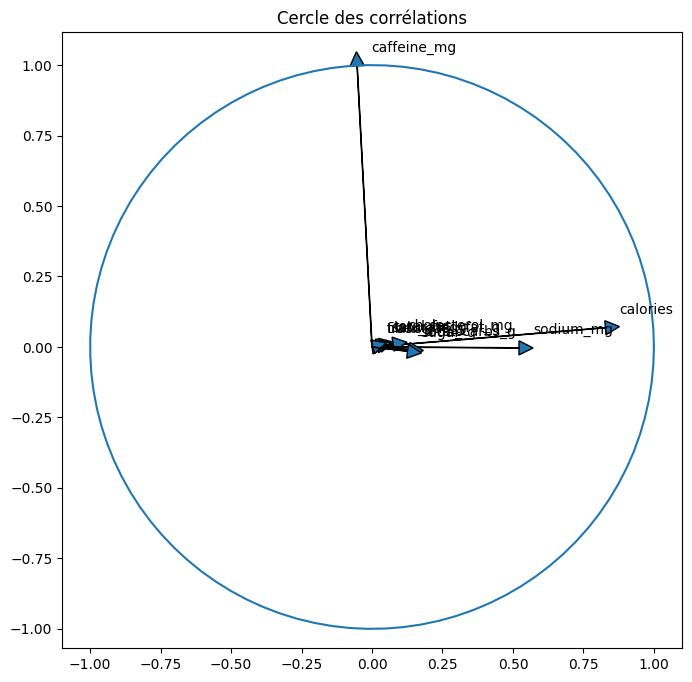

In [57]:
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls2.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls2.components_[0, i],  #0 for PC1
             cls2.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls2.components_[0, i] + 0.05,
             cls2.components_[1, i] + 0.05,
             starbucks_acp2.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations')
plot.show()

### Troisième essai : Sans *caffeine_mg*

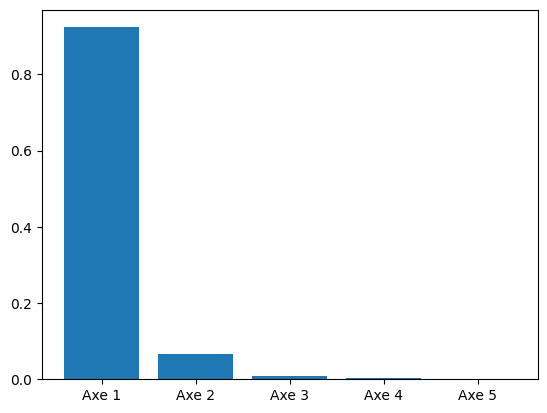

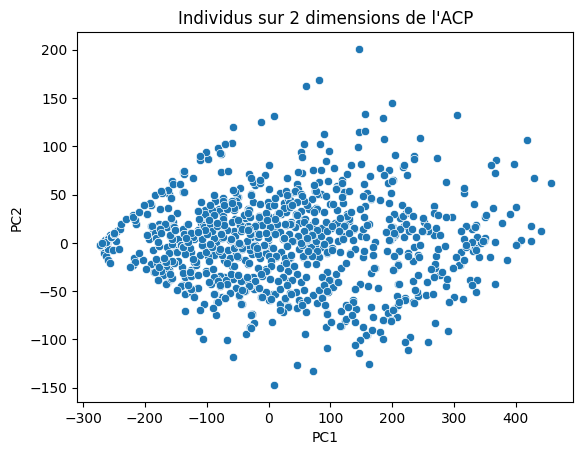

In [58]:
n_comp = 5
starbucks_acp3 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "Category", "serv_size_m_l", "caffeine_mg", "PC1", "PC2", "PC3", "PC4", "PC5"]).copy()

cls3 = PCA(n_components = n_comp)
pcs3 = cls3.fit_transform(starbucks_acp3)

plot.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"],cls3.explained_variance_ratio_)
plot.show()

for i in range(0, n_comp):
    starbucks['PC' + str(i + 1)] = pcs3[:, i]

sns.scatterplot(x="PC1", y="PC2", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP")
plot.show()

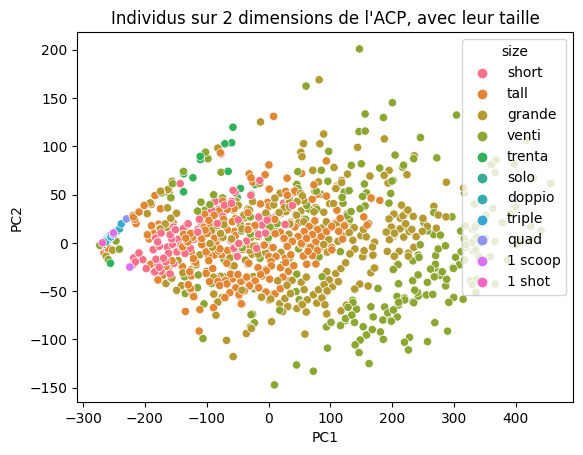

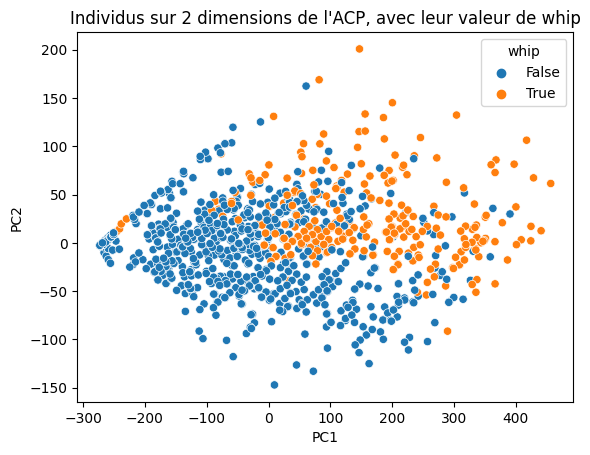

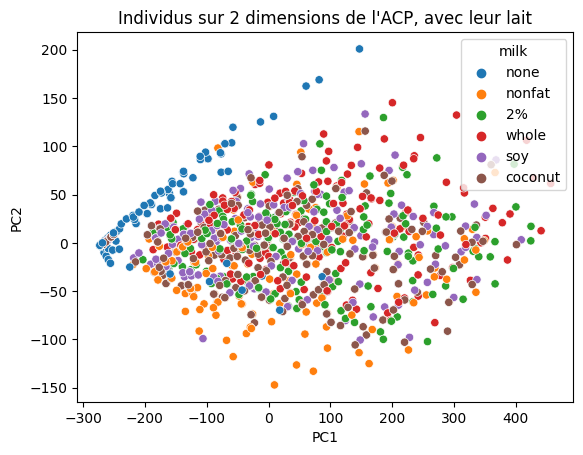

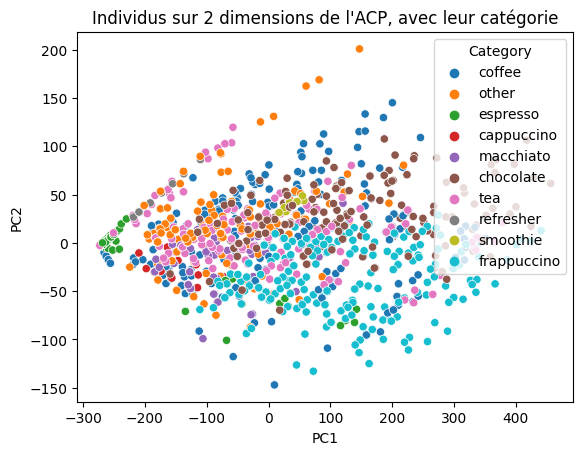

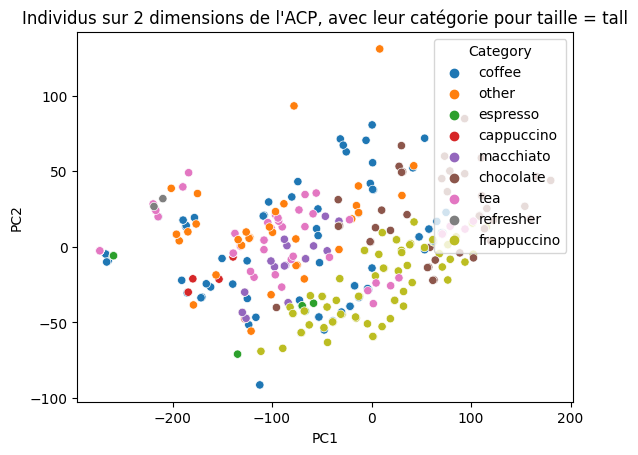

In [59]:
sns.scatterplot(x="PC1", y="PC2", hue="size", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
plot.show()

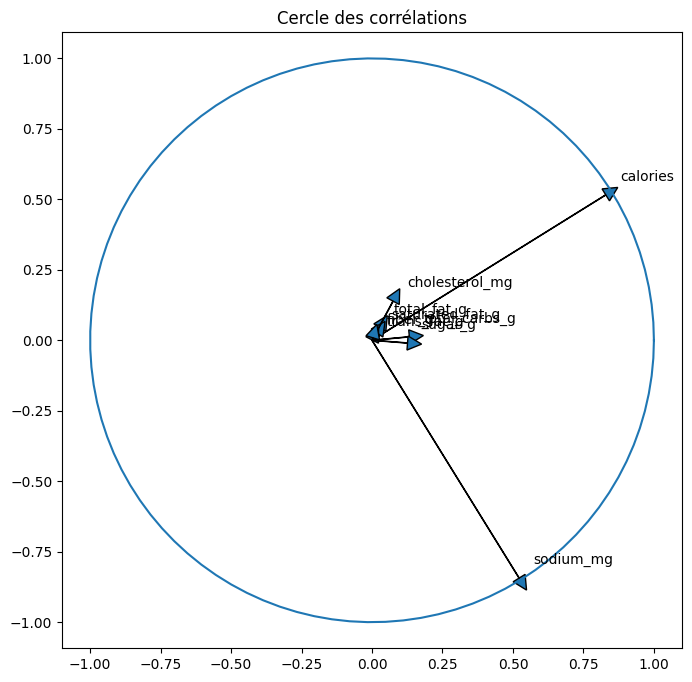

In [60]:
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls3.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls3.components_[0, i],  #0 for PC1
             cls3.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls3.components_[0, i] + 0.05,
             cls3.components_[1, i] + 0.05,
             starbucks_acp3.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations')
plot.show()